In [1]:
import os
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def concatenate_csv_files(folder_path):
    # List all CSV files in the folder
    csv_files = [file for file in os.listdir(folder_path) if file.endswith('.csv')]
    
    # If no CSV files found, exit
    if not csv_files:
        print("No CSV files found in the folder.")
        return
    
    # Initialize an empty DataFrame to store concatenated data
    concatenated_df = pd.DataFrame()

    # Concatenate all CSV files
    for csv_file in csv_files:
        file_path = os.path.join(folder_path, csv_file)
        df = pd.read_csv(file_path)
        df = df.dropna(subset='cycle_time')
        df['shot_id']= df['shot_id'].astype(int)
        df['cycle_time']= df['cycle_time'].astype(int)
        df['COUNTER_ID']= df['COUNTER_ID'].astype(str)
        df = df.drop_duplicates(['shot_id', 'COUNTER_ID'])
        concatenated_df = pd.concat([concatenated_df, df], ignore_index=True)
    
    return concatenated_df

In [3]:
def calculate_differences(df, column_name):
    for i in range(1, 2):
        # Forward differences
        df[f'diff_fwd_{i}'] = df[column_name].diff(periods=-i)
        df[f'diff_fwd_{i}'] = df[f'diff_fwd_{i}'].abs().round(2)

        # Backward differences
        df[f'diff_bck_{i}'] = df[column_name].diff(periods=i)
        df[f'diff_bck_{i}'] = df[f'diff_bck_{i}'].abs().round(2)
    tolerance = 2
    df.loc[ (df['diff_fwd_1'] <= tolerance) & (df['diff_bck_1'] <= tolerance), 'output'] = 1
    # df.loc[ (df['diff_fwd_1'] <= tolerance) & (df['diff_bck_1'] <= tolerance), 'output'] = 1
    return df

In [4]:
def plot_confusion_matrix(ground_truth=None, predictions=None, data_type=None):
        cm = confusion_matrix(ground_truth, predictions)

        # Calculate rates
        TN, FP, FN, TP = cm.ravel()
        # TP, FN, FP, TN = cm.ravel()
        print('True Positive: ', TP)
        print('False Positive: ', FP)
        print('True Negative: ', TN)
        print('False Negative: ', FN)
        TPR = TP / (TP + FN)
        TNR = TN / (TN + FP)
        FPR = FP / (FP + TN)
        FNR = FN / (FN + TP)

        # Plot confusion matrix
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm,
                    annot=True,
                    fmt='d',
                    cmap='Blues',
                    xticklabels=['Normal- 0', 'Anomoly - 1',  ],
                    yticklabels=['Normal- 0','Anomoly - 1' ]
                    )

        # Annotate with rates
        plt.text(0.5, 0.2, f'TNR: {TNR:.4f}', ha='center', va='center', color='red', fontsize=12, weight='bold')
        plt.text(1.5, 0.2, f'FPR: {FPR:.4f}', ha='center', va='center', color='red', fontsize=12, weight='bold')
        plt.text(0.5, 1.2, f'FNR: {FNR:.4f}', ha='center', va='center', color='red', fontsize=12, weight='bold')
        plt.text(1.5, 1.2, f'TPR: {TPR:.4f}', ha='center', va='center', color='red', fontsize=12, weight='bold')

        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title(f'Confusion Matrix of {data_type}')
        # plt.savefig(os.path.join(experiment_parent_dir, f'{data_type}_confusion_matrix.png'))
        plt.show()

### Create Ground Truth

- Normal Distribution

In [5]:
ground_truth_normal_distribution = concatenate_csv_files('normal_data_labelled')
ground_truth_normal_distribution = ground_truth_normal_distribution[['COUNTER_ID', 'cycle_time', 'value2','shot_id']]
ground_truth_normal_distribution.rename(columns={'value2': 'ground_truth'}, inplace=True)
ground_truth_normal_distribution['ground_truth'] = ground_truth_normal_distribution['ground_truth'].apply(lambda x: 0 if x == 2 else 1)
ground_truth_normal_distribution['ground_truth'] = 1 - ground_truth_normal_distribution['ground_truth'] # Inverting it for clarity 1 means anomoly and 0 means normal (1 is positive class and 0 is negatie class)
ground_truth_normal_distribution['shot_id'] = ground_truth_normal_distribution['shot_id'].astype(int)
ground_truth_normal_distribution['ground_truth'] = ground_truth_normal_distribution['ground_truth'].astype(int)
ground_truth_normal_distribution = ground_truth_normal_distribution.drop_duplicates(subset=['COUNTER_ID', 'cycle_time','shot_id'])
ground_truth_normal_distribution

,COUNTER_ID,cycle_time,ground_truth,shot_id
0,EMA2233M10017,57,0,1
1,EMA2233M10017,57,0,2
2,EMA2233M10017,57,0,3
3,EMA2233M10017,57,0,4
4,EMA2233M10017,57,0,5
...,...,...,...,...
22507,EMA2303M10302,32,0,3248
22508,EMA2303M10302,32,0,3249
22509,EMA2303M10302,32,0,3250
22510,EMA2303M10302,32,0,3251


- Anamalous Distribution

In [6]:
ground_truth_anomalous_distritbution = concatenate_csv_files('anomalous_data_labelled')
ground_truth_anomalous_distritbution = ground_truth_anomalous_distritbution.dropna(subset='cycle_time')
ground_truth_anomalous_distritbution = ground_truth_anomalous_distritbution[['COUNTER_ID', 'cycle_time', 'GT_Anomaly','shot_id']]
ground_truth_anomalous_distritbution['cycle_time'] = ground_truth_anomalous_distritbution['cycle_time'].astype(int)
ground_truth_anomalous_distritbution.rename(columns={'GT_Anomaly': 'ground_truth'}, inplace=True)
ground_truth_anomalous_distritbution['ground_truth'] = ground_truth_anomalous_distritbution['ground_truth'].replace('`1', '1')
ground_truth_anomalous_distritbution['ground_truth'] = ground_truth_anomalous_distritbution['ground_truth'].astype(int)
ground_truth_anomalous_distritbution

,COUNTER_ID,cycle_time,ground_truth,shot_id
0,EMA2233M10295,3,1,14687
1,EMA2233M10295,0,1,14688
2,EMA2233M10295,155,1,14689
3,EMA2233M10295,14,1,14690
4,EMA2233M10295,4,1,14691
...,...,...,...,...
140230,EMA2233M10308,59,0,7981
140231,EMA2233M10308,58,0,7982
140232,EMA2233M10308,196,1,7983
140233,EMA2233M10308,10,1,517


- Combined Distribution

In [7]:
ground_truth_combined_distritbution = pd.concat([ground_truth_anomalous_distritbution,ground_truth_normal_distribution])
ground_truth_combined_distritbution

,COUNTER_ID,cycle_time,ground_truth,shot_id
0,EMA2233M10295,3,1,14687
1,EMA2233M10295,0,1,14688
2,EMA2233M10295,155,1,14689
3,EMA2233M10295,14,1,14690
4,EMA2233M10295,4,1,14691
...,...,...,...,...
22507,EMA2303M10302,32,0,3248
22508,EMA2303M10302,32,0,3249
22509,EMA2303M10302,32,0,3250
22510,EMA2303M10302,32,0,3251


### Rule Base Results

- Normal Distribution

In [8]:
rule_base = concatenate_csv_files('normal_data_labelled_aist')
rule_base = rule_base[['shot_time','COUNTER_ID', 'cycle_time', 'value2','shot_id']]
rule_base['cycle_time'] = rule_base['cycle_time'].astype(int)
rule_base.rename(columns={'value2': 'output'}, inplace=True)
rule_base['output'] = rule_base['output'].apply(lambda x: 0 if x == 2 else 1)
rule_base['output'] = rule_base['output'].astype(int)
rule_base['output'] = 1 - rule_base['output']
rule_base

,shot_time,COUNTER_ID,cycle_time,output,shot_id
0,2024-03-21 14:39:09,EMA2233M10017,57,0,1
1,2024-03-21 14:40:07,EMA2233M10017,57,0,2
2,2024-03-21 14:41:05,EMA2233M10017,57,0,3
3,2024-03-21 14:42:02,EMA2233M10017,57,0,4
4,2024-03-21 14:43:00,EMA2233M10017,57,0,5
...,...,...,...,...,...
22507,2024-03-21 13:20:47,EMA2303M10302,32,0,3248
22508,2024-03-21 13:21:19,EMA2303M10302,32,0,3249
22509,2024-03-21 13:21:52,EMA2303M10302,32,0,3250
22510,2024-03-21 13:22:24,EMA2303M10302,32,0,3251


In [9]:
rule_base_normal_distritbution = pd.merge(ground_truth_normal_distribution, rule_base, 
                     on=[
                         'shot_id', 
                         'COUNTER_ID', 
                         'cycle_time'
                         ], 
                     how='inner')
rule_base_normal_distritbution

,COUNTER_ID,cycle_time,ground_truth,shot_id,shot_time,output
0,EMA2233M10017,57,0,1,2024-03-21 14:39:09,0
1,EMA2233M10017,57,0,2,2024-03-21 14:40:07,0
2,EMA2233M10017,57,0,3,2024-03-21 14:41:05,0
3,EMA2233M10017,57,0,4,2024-03-21 14:42:02,0
4,EMA2233M10017,57,0,5,2024-03-21 14:43:00,0
...,...,...,...,...,...,...
22507,EMA2303M10302,32,0,3248,2024-03-21 13:20:47,0
22508,EMA2303M10302,32,0,3249,2024-03-21 13:21:19,0
22509,EMA2303M10302,32,0,3250,2024-03-21 13:21:52,0
22510,EMA2303M10302,32,0,3251,2024-03-21 13:22:24,0


True Positive:  186
False Positive:  7
True Negative:  22306
False Negative:  13


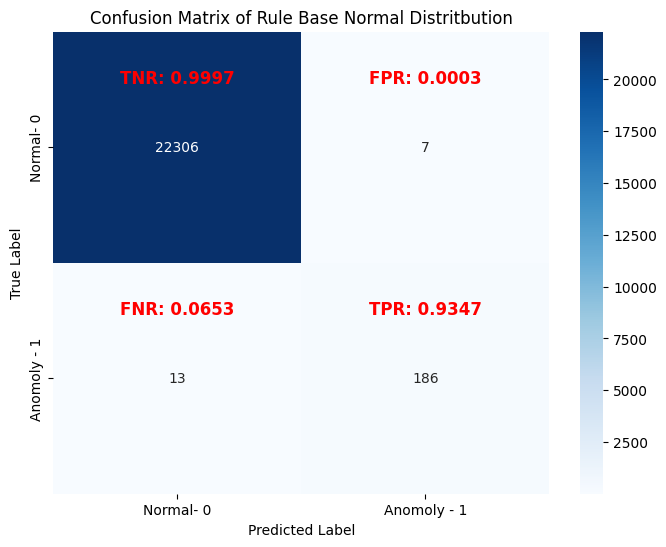

In [10]:
plot_confusion_matrix(rule_base_normal_distritbution['ground_truth'], rule_base_normal_distritbution['output'],'Rule Base Normal Distritbution')

- Anamalous Distribution

In [11]:
rule_base = concatenate_csv_files('anomalous_data_labelled_aist')
rule_base = rule_base[['shot_time','COUNTER_ID', 'cycle_time', 'value2','shot_id']]
rule_base['cycle_time'] = rule_base['cycle_time'].astype(int)
rule_base.rename(columns={'value2': 'output'}, inplace=True)
rule_base['output'] = rule_base['output'].apply(lambda x: 0 if x == 2 else 1)
rule_base['output'] = rule_base['output'].astype(int)
rule_base['output'] = 1 - rule_base['output']
rule_base

,shot_time,COUNTER_ID,cycle_time,output,shot_id
0,2022-02-21 13:19:08,EMA2233M10295,3,0,14687
1,2022-02-21 13:19:11,EMA2233M10295,0,0,14688
2,2022-02-21 13:19:12,EMA2233M10295,155,1,14689
3,2022-02-21 13:21:46,EMA2233M10295,14,1,14690
4,2022-02-21 13:22:00,EMA2233M10295,4,0,14691
...,...,...,...,...,...
140230,2023-12-21 12:19:05,EMA2233M10308,58,0,8122
140231,2023-12-21 12:20:03,EMA2233M10308,58,0,8123
140232,2023-12-21 12:21:02,EMA2233M10308,226,1,8124
140233,2024-01-25 07:50:47,EMA2233M10308,10,0,517


In [12]:
rule_base_anomalous_distritbution = pd.merge(ground_truth_anomalous_distritbution, rule_base, 
                     on=[
                         'shot_id', 
                         'COUNTER_ID', 
                         'cycle_time'
                         ], 
                     how='inner')
rule_base_anomalous_distritbution

,COUNTER_ID,cycle_time,ground_truth,shot_id,shot_time,output
0,EMA2233M10295,3,1,14687,2022-02-21 13:19:08,0
1,EMA2233M10295,0,1,14688,2022-02-21 13:19:11,0
2,EMA2233M10295,155,1,14689,2022-02-21 13:19:12,1
3,EMA2233M10295,14,1,14690,2022-02-21 13:21:46,1
4,EMA2233M10295,4,1,14691,2022-02-21 13:22:00,0
...,...,...,...,...,...,...
140230,EMA2233M10308,59,0,7981,2023-12-21 18:47:09,0
140231,EMA2233M10308,58,0,7982,2023-12-21 18:48:08,0
140232,EMA2233M10308,196,1,7983,2023-12-21 18:49:06,1
140233,EMA2233M10308,10,1,517,2024-01-25 07:50:47,0


True Positive:  2641
False Positive:  2705
True Negative:  134793
False Negative:  96


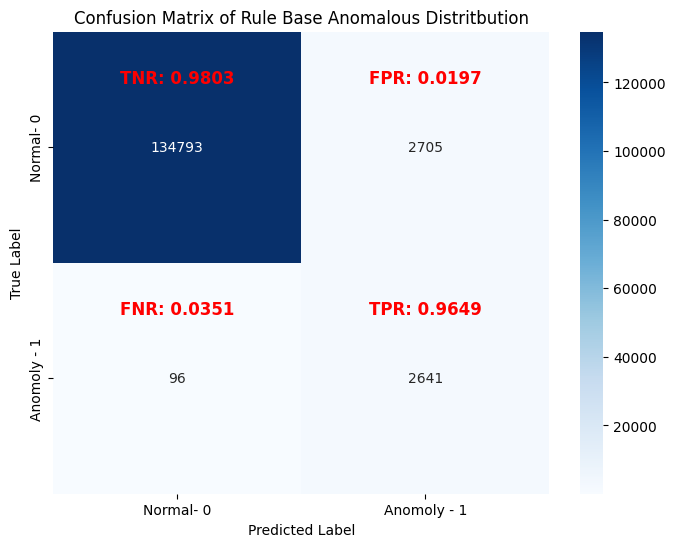

In [13]:
plot_confusion_matrix(rule_base_anomalous_distritbution['ground_truth'], rule_base_anomalous_distritbution['output'],'Rule Base Anomalous Distritbution')

- Combined Distribution

In [14]:
rule_based_combined = pd.concat([rule_base_anomalous_distritbution,rule_base_normal_distritbution])
rule_based_combined

,COUNTER_ID,cycle_time,ground_truth,shot_id,shot_time,output
0,EMA2233M10295,3,1,14687,2022-02-21 13:19:08,0
1,EMA2233M10295,0,1,14688,2022-02-21 13:19:11,0
2,EMA2233M10295,155,1,14689,2022-02-21 13:19:12,1
3,EMA2233M10295,14,1,14690,2022-02-21 13:21:46,1
4,EMA2233M10295,4,1,14691,2022-02-21 13:22:00,0
...,...,...,...,...,...,...
22507,EMA2303M10302,32,0,3248,2024-03-21 13:20:47,0
22508,EMA2303M10302,32,0,3249,2024-03-21 13:21:19,0
22509,EMA2303M10302,32,0,3250,2024-03-21 13:21:52,0
22510,EMA2303M10302,32,0,3251,2024-03-21 13:22:24,0


In [15]:
rule_base_combined_distritbution = pd.merge(ground_truth_combined_distritbution, rule_based_combined, 
                     on=[
                         'shot_id', 
                         'COUNTER_ID', 
                         'cycle_time'
                         ], 
                     how='inner')
rule_base_combined_distritbution

,COUNTER_ID,cycle_time,ground_truth_x,shot_id,ground_truth_y,shot_time,output
0,EMA2233M10295,3,1,14687,1,2022-02-21 13:19:08,0
1,EMA2233M10295,0,1,14688,1,2022-02-21 13:19:11,0
2,EMA2233M10295,155,1,14689,1,2022-02-21 13:19:12,1
3,EMA2233M10295,14,1,14690,1,2022-02-21 13:21:46,1
4,EMA2233M10295,4,1,14691,1,2022-02-21 13:22:00,0
...,...,...,...,...,...,...,...
162742,EMA2303M10302,32,0,3248,0,2024-03-21 13:20:47,0
162743,EMA2303M10302,32,0,3249,0,2024-03-21 13:21:19,0
162744,EMA2303M10302,32,0,3250,0,2024-03-21 13:21:52,0
162745,EMA2303M10302,32,0,3251,0,2024-03-21 13:22:24,0


True Positive:  2641
False Positive:  2705
True Negative:  134793
False Negative:  96


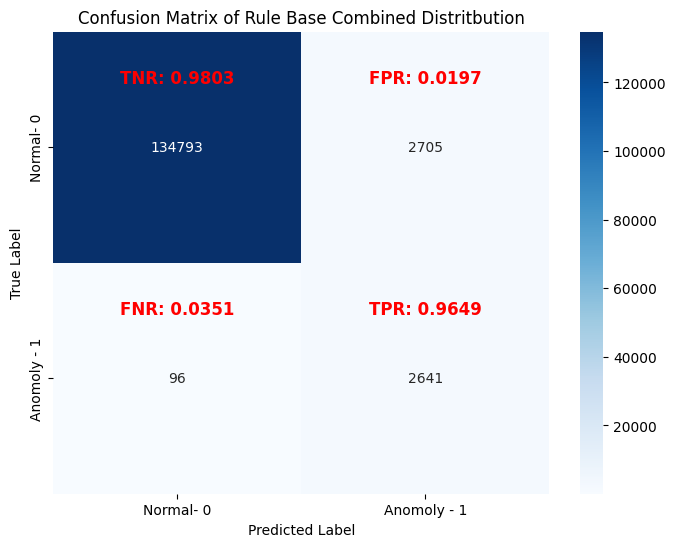

In [16]:
plot_confusion_matrix(rule_base_anomalous_distritbution['ground_truth'], rule_base_anomalous_distritbution['output'],'Rule Base Combined Distritbution')

## Isolation Forest Results

### EXP - 1

In [17]:
if_result = concatenate_csv_files('if_results_normal_default_parameters')
if_result['output'] = if_result['output'].astype(int)
if_result = calculate_differences(if_result, 'cycle_time')
combined_result = pd.merge(ground_truth_normal_distribution, if_result, 
                     on=[
                         'shot_id', 
                         'COUNTER_ID', 
                         'cycle_time'
                         ], 
                     how='inner')
combined_result

,COUNTER_ID,cycle_time,ground_truth,shot_id,shot_time,anomoly_score,anomoly_score_inverse,output,diff_fwd_1,diff_bck_1
0,EMA2233M10017,57,0,1,3/21/2024 14:39,0.140314,0.640314,0,0.0,NaN
1,EMA2233M10017,57,0,2,3/21/2024 14:40,0.140314,0.640314,1,0.0,0.0
2,EMA2233M10017,57,0,3,3/21/2024 14:41,0.140314,0.640314,1,0.0,0.0
3,EMA2233M10017,57,0,4,3/21/2024 14:42,0.140314,0.640314,1,0.0,0.0
4,EMA2233M10017,57,0,5,3/21/2024 14:43,0.140314,0.640314,1,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
22507,EMA2303M10302,32,0,3248,3/21/2024 13:20,0.032960,0.532960,1,0.0,0.0
22508,EMA2303M10302,32,0,3249,3/21/2024 13:21,0.032960,0.532960,1,0.0,0.0
22509,EMA2303M10302,32,0,3250,3/21/2024 13:21,0.032960,0.532960,1,0.0,0.0
22510,EMA2303M10302,32,0,3251,3/21/2024 13:22,0.032960,0.532960,1,0.0,0.0


True Positive:  193
False Positive:  22101
True Negative:  212
False Negative:  6


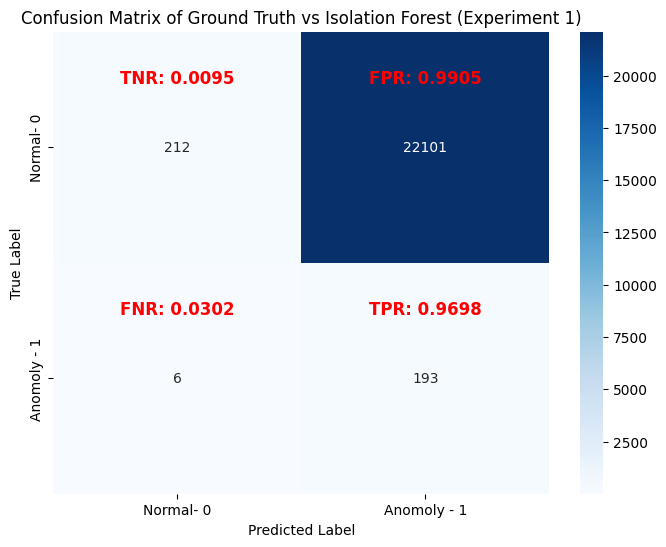

In [20]:
plot_confusion_matrix(combined_result['ground_truth'], combined_result['output'],'Ground Truth vs Isolation Forest (Experiment 1)')

### EXP - 2

In [21]:
if_result = concatenate_csv_files('if_results_anomalous_default_parameters')
if_result['output'] = if_result['output'].astype(int)
if_result = calculate_differences(if_result, 'cycle_time')
combined_result = pd.merge(ground_truth_anomalous_distritbution, if_result, 
                     on=[
                         'shot_id', 
                         'COUNTER_ID', 
                         'cycle_time'
                         ], 
                     how='inner')
combined_result

,COUNTER_ID,cycle_time,ground_truth,shot_id,shot_time,anomoly_score,anomoly_score_inverse,output,diff_fwd_1,diff_bck_1
0,EMA2233M10295,3,1,14687,2022-02-21 13:19:08,-0.230311,0.269689,1,3.0,NaN
1,EMA2233M10295,0,1,14688,2022-02-21 13:19:11,-0.230311,0.269689,1,155.0,3.0
2,EMA2233M10295,155,1,14689,2022-02-21 13:19:12,-0.299788,0.200212,1,141.0,155.0
3,EMA2233M10295,14,1,14690,2022-02-21 13:21:46,-0.226861,0.273139,1,10.0,141.0
4,EMA2233M10295,4,1,14691,2022-02-21 13:22:00,-0.230311,0.269689,1,86.0,10.0
...,...,...,...,...,...,...,...,...,...,...
140230,EMA2233M10308,59,0,7981,2023-12-21 18:47:09,0.086530,0.586530,1,1.0,1.0
140231,EMA2233M10308,58,0,7982,2023-12-21 18:48:08,0.131517,0.631517,0,138.0,1.0
140232,EMA2233M10308,196,1,7983,2023-12-21 18:49:06,-0.296655,0.203345,1,186.0,138.0
140233,EMA2233M10308,10,1,517,2024-01-25 07:50:47,-0.207651,0.292349,1,2.0,186.0


True Positive:  2724
False Positive:  130338
True Negative:  7160
False Negative:  13


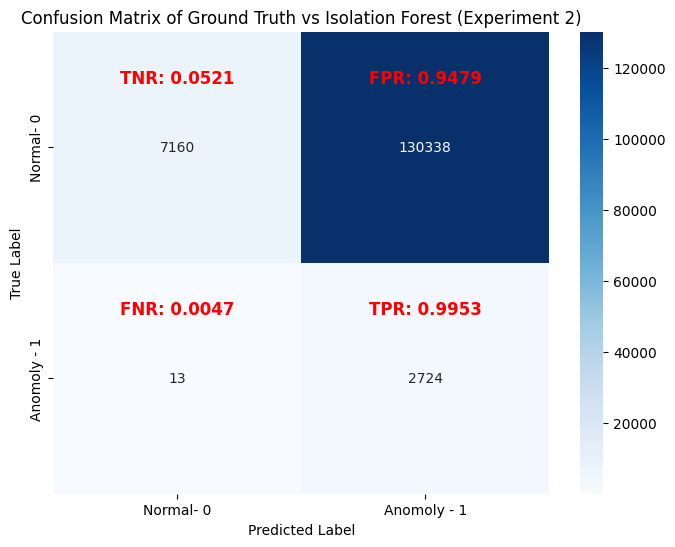

In [22]:
plot_confusion_matrix(combined_result['ground_truth'], combined_result['output'],'Ground Truth vs Isolation Forest (Experiment 2)')

### EXP - 3

In [23]:
if_result = concatenate_csv_files('if_results_normal_tuned_parameters')
if_result['output'] = if_result['output'].astype(int)
if_result = calculate_differences(if_result, 'cycle_time')

combined_result = pd.merge(ground_truth_normal_distribution, if_result, 
                     on=[
                         'shot_id', 
                         'COUNTER_ID', 
                         'cycle_time'
                         ], 
                     how='inner')
combined_result

,COUNTER_ID,cycle_time,ground_truth,shot_id,shot_time,anomoly_score,anomoly_score_inverse,output,diff_fwd_1,diff_bck_1
0,EMA2233M10017,57,0,1,2024-03-21 14:39:09,0.136203,0.636203,0,0.0,NaN
1,EMA2233M10017,57,0,2,2024-03-21 14:40:07,0.136203,0.636203,1,0.0,0.0
2,EMA2233M10017,57,0,3,2024-03-21 14:41:05,0.136203,0.636203,1,0.0,0.0
3,EMA2233M10017,57,0,4,2024-03-21 14:42:02,0.136203,0.636203,1,0.0,0.0
4,EMA2233M10017,57,0,5,2024-03-21 14:43:00,0.136203,0.636203,1,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
22507,EMA2303M10302,32,0,3248,2024-03-21 13:20:47,0.049536,0.549536,1,0.0,0.0
22508,EMA2303M10302,32,0,3249,2024-03-21 13:21:19,0.049536,0.549536,1,0.0,0.0
22509,EMA2303M10302,32,0,3250,2024-03-21 13:21:52,0.049536,0.549536,1,0.0,0.0
22510,EMA2303M10302,32,0,3251,2024-03-21 13:22:24,0.049536,0.549536,1,0.0,0.0


True Positive:  194
False Positive:  22037
True Negative:  276
False Negative:  5


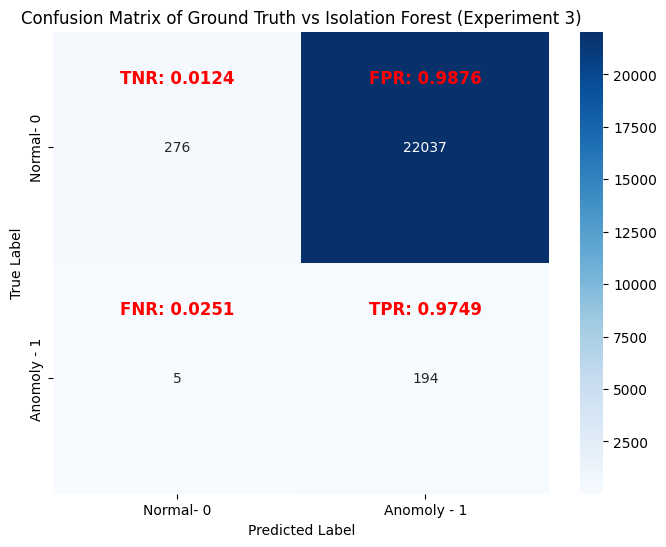

In [24]:
plot_confusion_matrix(combined_result['ground_truth'], combined_result['output'],'Ground Truth vs Isolation Forest (Experiment 3)')

### EXP - 4

In [25]:
if_result = concatenate_csv_files('if_results_anomolaus_tuned_parameters')
if_result['output'] = if_result['output'].astype(int)
if_result = calculate_differences(if_result, 'cycle_time')
combined_result = pd.merge(ground_truth_anomalous_distritbution, if_result, 
                     on=[
                         'shot_id', 
                         'COUNTER_ID', 
                         'cycle_time'
                         ], 
                     how='inner')
combined_result

,COUNTER_ID,cycle_time,ground_truth,shot_id,shot_time,anomoly_score,anomoly_score_inverse,output,diff_fwd_1,diff_bck_1
0,EMA2233M10295,3,1,14687,2022-02-21 13:19:08,-0.270076,0.229924,1,3.0,NaN
1,EMA2233M10295,0,1,14688,2022-02-21 13:19:11,-0.276918,0.223082,1,155.0,3.0
2,EMA2233M10295,155,1,14689,2022-02-21 13:19:12,-0.232305,0.267695,1,141.0,155.0
3,EMA2233M10295,14,1,14690,2022-02-21 13:21:46,-0.239043,0.260957,1,10.0,141.0
4,EMA2233M10295,4,1,14691,2022-02-21 13:22:00,-0.268564,0.231436,1,86.0,10.0
...,...,...,...,...,...,...,...,...,...,...
140230,EMA2233M10308,59,0,7981,2023-12-21 18:47:09,0.118591,0.618591,1,1.0,1.0
140231,EMA2233M10308,58,0,7982,2023-12-21 18:48:08,0.144030,0.644030,0,138.0,1.0
140232,EMA2233M10308,196,1,7983,2023-12-21 18:49:06,-0.226110,0.273890,1,186.0,138.0
140233,EMA2233M10308,10,1,517,2024-01-25 07:50:47,-0.239975,0.260025,1,2.0,186.0


True Positive:  2609
False Positive:  128733
True Negative:  8765
False Negative:  128


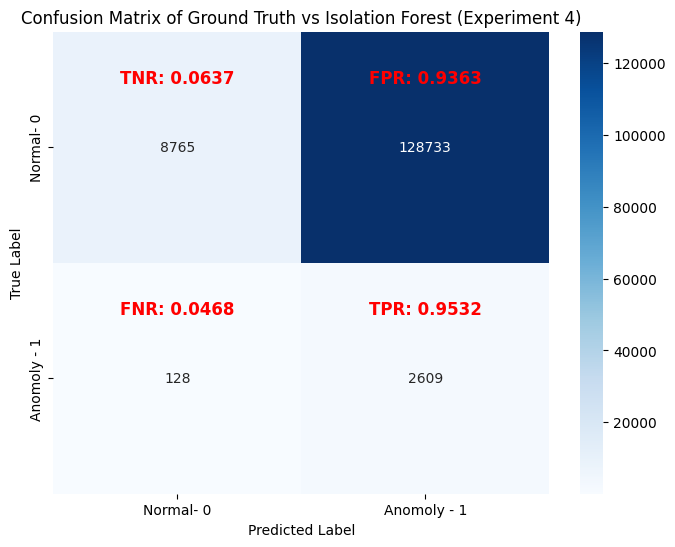

In [26]:
plot_confusion_matrix(combined_result['ground_truth'], combined_result['output'],'Ground Truth vs Isolation Forest (Experiment 4)')

### EXP - 5

In [27]:
if_result = concatenate_csv_files('if_results_combined_data_tuned_parameters')
if_result['output'] = if_result['output'].astype(int)
if_result = calculate_differences(if_result, 'cycle_time')
if_result

,shot_time,COUNTER_ID,cycle_time,shot_id,anomoly_score,anomoly_score_inverse,output,diff_fwd_1,diff_bck_1
0,2022-02-21 13:19:08,EMA2233M10295,3,14687,-0.318193,0.230034,1,3.0,NaN
1,2022-02-21 13:19:11,EMA2233M10295,0,14688,-0.339050,0.209176,1,155.0,3.0
2,2022-02-21 13:19:12,EMA2233M10295,155,14689,-0.174725,0.373501,1,141.0,155.0
3,2022-02-21 13:21:46,EMA2233M10295,14,14690,-0.215252,0.332974,1,10.0,141.0
4,2022-02-21 13:22:00,EMA2233M10295,4,14691,-0.310917,0.237309,1,86.0,10.0
...,...,...,...,...,...,...,...,...,...
162742,2024-03-21 13:20:47,EMA2303M10302,32,3248,-0.020913,0.527313,1,0.0,0.0
162743,2024-03-21 13:21:19,EMA2303M10302,32,3249,-0.020913,0.527313,1,0.0,0.0
162744,2024-03-21 13:21:52,EMA2303M10302,32,3250,-0.020913,0.527313,1,0.0,0.0
162745,2024-03-21 13:22:24,EMA2303M10302,32,3251,-0.020913,0.527313,1,0.0,0.0


In [28]:
combined_result = pd.merge(ground_truth_combined_distritbution, if_result, 
                     on=[
                         'shot_id', 
                         'COUNTER_ID', 
                         'cycle_time'
                         ], 
                     how='inner')
combined_result

,COUNTER_ID,cycle_time,ground_truth,shot_id,shot_time,anomoly_score,anomoly_score_inverse,output,diff_fwd_1,diff_bck_1
0,EMA2233M10295,3,1,14687,2022-02-21 13:19:08,-0.318193,0.230034,1,3.0,NaN
1,EMA2233M10295,0,1,14688,2022-02-21 13:19:11,-0.339050,0.209176,1,155.0,3.0
2,EMA2233M10295,155,1,14689,2022-02-21 13:19:12,-0.174725,0.373501,1,141.0,155.0
3,EMA2233M10295,14,1,14690,2022-02-21 13:21:46,-0.215252,0.332974,1,10.0,141.0
4,EMA2233M10295,4,1,14691,2022-02-21 13:22:00,-0.310917,0.237309,1,86.0,10.0
...,...,...,...,...,...,...,...,...,...,...
162742,EMA2303M10302,32,0,3248,2024-03-21 13:20:47,-0.020913,0.527313,1,0.0,0.0
162743,EMA2303M10302,32,0,3249,2024-03-21 13:21:19,-0.020913,0.527313,1,0.0,0.0
162744,EMA2303M10302,32,0,3250,2024-03-21 13:21:52,-0.020913,0.527313,1,0.0,0.0
162745,EMA2303M10302,32,0,3251,2024-03-21 13:22:24,-0.020913,0.527313,1,0.0,0.0


True Positive:  2544
False Positive:  150537
True Negative:  9274
False Negative:  392


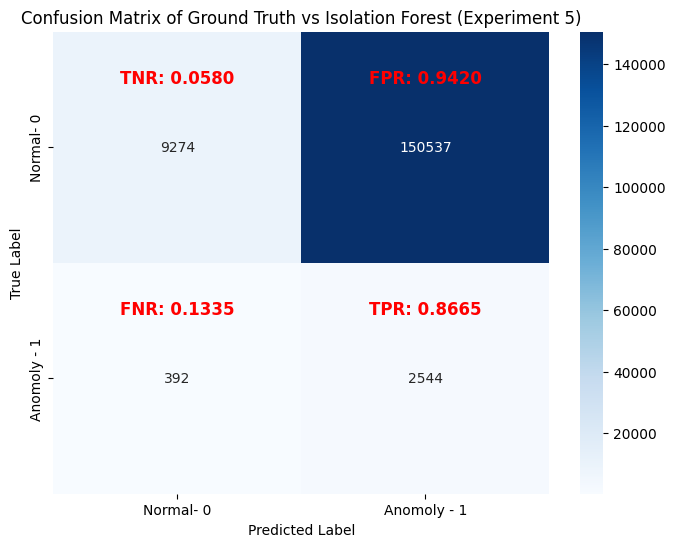

In [29]:
plot_confusion_matrix(combined_result['ground_truth'], combined_result['output'],'Ground Truth vs Isolation Forest (Experiment 5)')